This is not the latest version, the latest version is in the hard drive. I will update it afterwards

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import keras 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

2024-11-21 15:22:48.681086: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 15:22:48.704921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 15:22:48.704948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 15:22:48.705590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 15:22:48.709400: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set the environment variable to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
labels_df = pd.read_csv("/home/elahed/users/elahe/project with aws/all_steering_concat_plus_3000_plus_19000_plus_10000_normalized_4000.csv")
images_directory = '/home/elahed/users/elahe/project with aws/all_mix/'
labels = []
image_path = []
Image_and_label = []
# Iterate through the rows of the DataFrame
for index, row in labels_df.iterrows():
    labels.append([row['Steering']])
    image_path.append(os.path.join(images_directory, row['Image_Fname']+'.png'))  # Replace with the actual column name
    Image_and_label.append([os.path.join(images_directory, row['Image_Fname']+'.png'),row['Steering'],row['Throttle'],row['Brake']])

In [4]:
len(labels)

47312

In [5]:
print(labels)

[[-0.0001757331192493], [-0.0290558170527219], [-0.1157644242048263], [-0.2011808156967163], [-0.238523855805397], [-0.2518028318881988], [-0.3324058353900909], [-0.2487750351428985], [-0.167343869805336], [-0.0023876449558883], [0.0], [-0.0629938170313835], [-0.0634987875819206], [-0.0326580218970775], [-0.0685752630233764], [-0.0836720541119575], [-0.046024352312088], [-0.1219454854726791], [-0.0946602448821067], [-0.0856046751141548], [-0.0696641653776168], [-0.0862034857273101], [-0.0622783452272415], [-0.0284488014876842], [-0.0559873953461647], [-0.0418493002653121], [-0.0448765717446804], [-0.0551973357796669], [-0.1086793765425682], [-0.0587753430008888], [-0.0655750036239624], [-0.1178614124655723], [-0.0470511801540851], [-0.0145525112748146], [-0.0251891426742076], [-0.0871316045522689], [-0.0933011397719383], [-0.0363113097846508], [-0.0739417821168899], [-0.0522760711610317], [-0.10768523812294], [-0.0739441886544227], [-0.0685727298259735], [-0.0712684914469719], [-0.0345

In [6]:
print(labels[0])

[-0.0001757331192493]


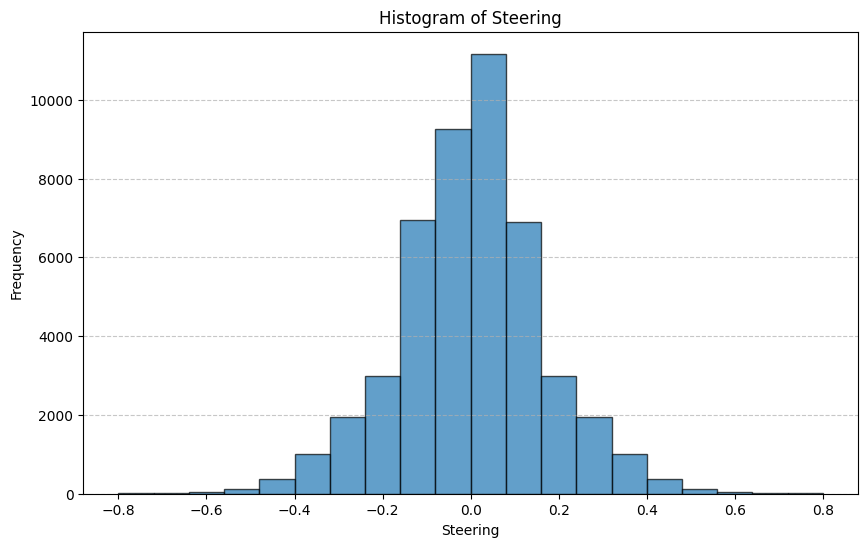

In [7]:
import matplotlib.pyplot as plt

# Plot the histogram for the 'Steering' column
column_name = 'Steering'

plt.figure(figsize=(10, 6))
plt.hist(labels_df[column_name], bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of {column_name}")
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [8]:
def flipping(img, steering):
    flip_image = cv2.flip(img,1)
    flip_steering = steering*-1.0
    return flip_image, flip_steering

def brightness(img,steering):
    bright_limit = (-0.5, 0.15)
    brightness_multiplier = 1.0 + np.random.uniform(low=bright_limit[0], high=bright_limit[1])
    image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image_hsv[:,:,2] = image_hsv[:,:,2] * brightness_multiplier
    bright_image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return bright_image , steering

In [9]:
class My_Custom_Generator1(keras.utils.Sequence) :
  
    def __init__(self, image_filenames, labels, batch_size,augment) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
    
    
    def __len__(self) :
        return (np.floor(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        inputs = []
        outputs = []

        for filename, labels in zip(batch_x, batch_y):
            
            inputs.append(cv2.resize(cv2.imread(filename) , (160,160)))
            outputs.append(labels[0])
            #print('labels',labels)
            #print('labels[0]',labels[0])
            #outputs.append(labels)


            if self.augment[0] == 'Flip':
                image , steer = flipping(cv2.resize(cv2.imread(filename) , (160,160)),labels[0])
                inputs.append(image)
                outputs.append(steer)

            if self.augment[1] == 'bright':
                image , steer = brightness(cv2.resize(cv2.imread(filename) , (160,160)),labels[0])
                inputs.append(image)
                outputs.append(steer)

        inputs_final = np.array(inputs).astype("float32")/255.0 
        outputs = np.array(outputs).astype("float32")
        return inputs_final, outputs
        

In [10]:
batch_size = 64
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(image_path,labels, test_size=0.1,shuffle=True)
train_generator = My_Custom_Generator1(X_train_data, y_train_data, batch_size,augment =["no","bright"] )
valid_generator = My_Custom_Generator1(X_valid_data, y_valid_data, batch_size,augment =["no","bright"] )

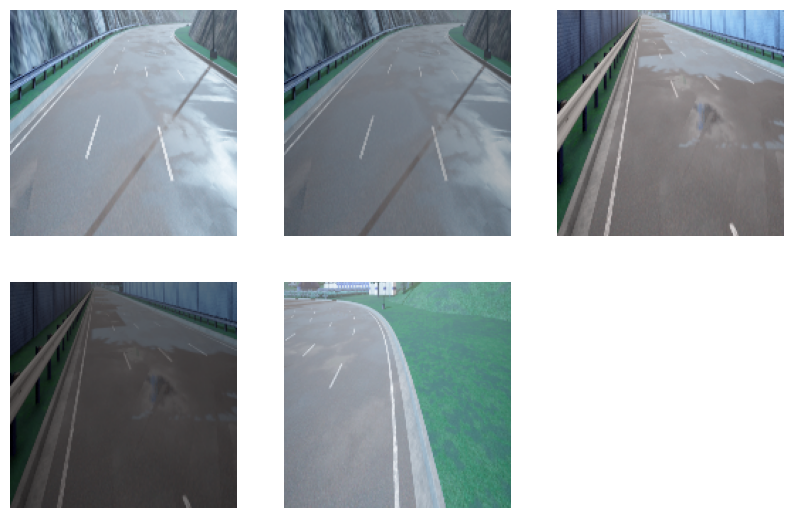

In [11]:
# Generate and plot 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    augmented_image = train_generator[0][0][i]
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.show()

In [10]:
len(X_train_data)

42580

In [11]:

def get_model():
    inputs_img = tf.keras.Input(shape=(160, 160, 3), name='input_image')

    # Conv block 1
    x = Conv2D(32, (5, 5), strides=2, padding='valid', name='conv1')(inputs_img)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)


    x = Conv2D(32, (3, 3), strides=1, padding='valid', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu', name='relu2')(x)

    # Conv block 2
    x = Conv2D(64, (3, 3), strides=2, padding='valid', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu', name='relu3')(x)

    x = Conv2D(64, (3, 3), strides=1, padding='valid', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu', name='relu4')(x)

    # Conv block 3
    x = Conv2D(128, (3, 3), strides=2, padding='valid', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu', name='relu5')(x)
    x = Dropout(rate=0.2, name='dropout5')(x)

    x = Conv2D(128, (3, 3), strides=1, padding='valid', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu', name='relu6')(x)

    # Conv block 4
    x = Conv2D(256, (3, 3), strides=1, padding='valid', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu', name='relu7')(x)

    x = Conv2D(256, (3, 3), strides=1, padding='valid', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu', name='relu8')(x)

    x = Flatten()(x)

    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2, name='dropout9')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(rate=0.2, name='dropout10')(x)
    x = Dense(256, activation='relu', name='fc3')(x)

    output = Dense(1, name='fc4')(x)
    model_input = inputs_img
    model_output = output
    model = keras.Model(model_input, model_output)
    return model

IL_model = get_model()
IL_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 78, 78, 32)        2432      
                                                                 
 bn1 (BatchNormalization)    (None, 78, 78, 32)        128       
                                                                 
 relu1 (Activation)          (None, 78, 78, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 76, 76, 32)        9248      
                                                                 
 bn2 (BatchNormalization)    (None, 76, 76, 32)        128       
                                                                 
 relu2 (Activation)          (None, 76, 76, 32)        0     

2024-11-21 10:14:27.738195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 10:14:27.759604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 10:14:27.759745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(IL_model, to_file='model.pdf', show_shapes=True, show_layer_names=True)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint directory and file format
#checkpoint_path = 'IL_model_22_all_plus_3000_retrain_turn_only_then_back_into_lane_ckpt.10-0.003.h5'
#IL_model.load_weights(checkpoint_path)

In [14]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.96)
optimizer_mine = keras.optimizers.Adam(learning_rate=lr_schedule)

2024-11-21 10:14:28.182208: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [15]:
# Specify the directory where TensorBoard logs will be stored
log_dir = "town06_all_bs64"

# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Checkpoint to save the best weights
model_ckpt_name = "IL_model_all_bs64"
checkpoint = ModelCheckpoint(model_ckpt_name + '_best.h5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Early stopping with restore_best_weights enabled
patience = 10
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=patience, 
                          verbose=1, 
                          mode='min', 
                          restore_best_weights=True)

# Combine all callbacks
callbacks = [checkpoint, earlystop, tensorboard_callback]

# Compile the model
IL_model.compile(optimizer=optimizer_mine, loss='MSE')

# Train the model
train_hist = IL_model.fit(train_generator,  
                          steps_per_epoch=len(X_train_data) // batch_size, 
                          epochs=500, 
                          validation_data=valid_generator,
                          validation_steps=len(X_valid_data) // batch_size,
                          shuffle=True,
                          verbose=1, 
                          callbacks=callbacks,
                          use_multiprocessing=True,
                          workers=8)


Epoch 1/500


2024-11-21 10:14:30.678257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-21 10:14:32.210490: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-21 10:14:32.265333: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-21 10:14:34.800025: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fca9ce813b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-21 10:14:34.800049: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-21 10:14:34.805788: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer

665/665 [==============================] - ETA: 0s - loss: 4.0651
Epoch 1: val_loss improved from inf to 0.03219, saving model to IL_model_all_bs64_best.h5


/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


665/665 [==============================] - 130s 179ms/step - loss: 4.0651 - val_loss: 0.0322
Epoch 2/500
665/665 [==============================] - ETA: 0s - loss: 0.0368
Epoch 2: val_loss improved from 0.03219 to 0.02521, saving model to IL_model_all_bs64_best.h5
665/665 [==============================] - 120s 178ms/step - loss: 0.0368 - val_loss: 0.0252
Epoch 3/500
665/665 [==============================] - ETA: 0s - loss: 0.0271
Epoch 3: val_loss improved from 0.02521 to 0.02063, saving model to IL_model_all_bs64_best.h5
665/665 [==============================] - 120s 178ms/step - loss: 0.0271 - val_loss: 0.0206
Epoch 4/500
665/665 [==============================] - ETA: 0s - loss: 0.0225
Epoch 4: val_loss improved from 0.02063 to 0.01783, saving model to IL_model_all_bs64_best.h5
665/665 [==============================] - 120s 178ms/step - loss: 0.0225 - val_loss: 0.0178
Epoch 5/500
665/665 [==============================] - ETA: 0s - loss: 0.0199
Epoch 5: val_loss improved from 0.

In [16]:
IL_model.save('IL_town06_steer_bs_64.keras')
IL_model.save('IL_town06_steer_bs_64.h5')